In [4]:
import os
import pandas as pd
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

from matplotlib import dates
import datetime

from heapq import nsmallest

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
import seaborn as sns
from neuralprophet import NeuralProphet, set_log_level

import warnings

In [5]:
holidays=['2020-01-01','2020-01-06','2020-04-12','2020-04-13','2020-05-01','2020-05-03',
          '2020-05-31', '2020-06-11','2020-08-15','2020-11-01','2020-11-11','2020-12-25',
          '2020-12-26','2021-01-01','2021-01-06','2021-04-04','2021-04-05','2021-05-01',
          '2021-05-03','2021-05-23','2021-06-03','2021-08-15','2021-11-01','2021-11-11',
          '2021-12-25','2021-12-26', '2022-01-01','2022-01-06', '2022-04-01','2022-04-02','2022-04-03','2022-04-04','2022-04-05',
          '2022-04-27','2022-04-28','2022-04-29','2022-04-30',
          '2022-05-01', '2022-05-02','2022-05-03','2022-05-04',
          '2022-05-23','2022-06-03','2022-08-15','2022-11-01','2022-11-11',
          '2022-12-25','2022-12-26'
         ]

state = pd.DataFrame({'ds': pd.to_datetime(holidays),
                      'holiday': 'state_holiday'
                      })
holidays = state

In [6]:
path = os.getcwd()
files = os.listdir(path)
files_csv = [f for f in files if f[:6] == 'zakupy']

In [7]:
df = pd.DataFrame()
for f in files_csv:
    data = pd.read_excel(f)
    df = df.append(data)

df.head(3)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_18120/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_18120/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_18120/1046609750.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(data)



,NumerZlecenia,LokalizacjaAkcji,LokalizacjaPoczatkowa,LokalizacjaKoncowa,CzasPrzejazdu,PrzebytyDystans,SredniaPredkosc,OcenaJazdyExpress,OcenaPredkosciExpress,OcenaOgolnaExpress,...,SamochodId,NumerRejestracyjny,Subsystem,Stan,DataDodania,Uwagi,SklepTrafiszopId,NazwaSklepu,AdresSklepu,MiastoSklepu
0,ZT/2021/2248344,Kraków,"Kraków, Tyniecka 188","Kraków, Tyniecka 188",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,brak,Zamkniete,2021-01-01 12:05:50.7683578,Osoba kontaktowa: 508905857 | Godzina dostar...,4,SPOŁEM Kraków,Daszyńskiego 3 31-537 Kraków,Kraków
1,ZT/2021/2248353,Łódź,"Łódź, ul. Żeligowskiego 8/10 - 24h","Łódź, ul. Żeligowskiego 8/10 - 24h",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,brak,Zamkniete,2021-01-01 12:34:11.5504132,Osoba kontaktowa: 608824286 | Godzina dostar...,28,Carrefour Bandurskiego,Bandurskiego 49 94-020 Łódź,Łódź
2,ZT/2021/2248355,Katowice,"Katowice, Siemianowicka 52C - 24h","Katowice, Siemianowicka 52C - 24h",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,brak,Zamkniete,2021-01-01 13:02:39.4225176,Osoba kontaktowa: 511461537 Notatka klienta: ...,3,SPOŁEM Katowice,Mickiewicza 4 40-954 Katowice,Katowice


In [8]:
df=df.reset_index()
del df['index']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155773 entries, 0 to 155772
Data columns (total 36 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   NumerZlecenia                 155773 non-null  object 
 1   LokalizacjaAkcji              154854 non-null  object 
 2   LokalizacjaPoczatkowa         155773 non-null  object 
 3   LokalizacjaKoncowa            155773 non-null  object 
 4   CzasPrzejazdu                 872 non-null     float64
 5   PrzebytyDystans               872 non-null     float64
 6   SredniaPredkosc               872 non-null     float64
 7   OcenaJazdyExpress             872 non-null     float64
 8   OcenaPredkosciExpress         872 non-null     float64
 9   OcenaOgolnaExpress            872 non-null     float64
 10  NajwyzszaPredkosc             872 non-null     float64
 11  OcenaRezerwacjiCms            0 non-null       float64
 12  IdWsparciaCms                 0 non-null    

In [9]:
#Lokalizacje akcji zapełnic miastem sklepu
df.LokalizacjaAkcji.fillna(df.MiastoSklepu, inplace=True)
#Wyrzucenie kolumn z brakiem DatyRozpoczęcia / data rozpoczęcia może wystąpić w następnych dniach od planowanej
df = df.dropna(subset=['DataRozpoczecia'])
df=df.reset_index()
del df['index']

In [10]:
# zmiana formatu daty na datetime
df['PlanowanaDataRozpoczecia']= pd.to_datetime(df['PlanowanaDataRozpoczecia'])
df['PlanowanaDataZakonczenia']= pd.to_datetime(df['PlanowanaDataZakonczenia'])
df['DataZakonczenia']= pd.to_datetime(df['DataZakonczenia'])
df['ZadeklarowanaData']= pd.to_datetime(df['ZadeklarowanaData'])
df['DataRozpoczecia']= pd.to_datetime(df['DataRozpoczecia'])
df['DataDodania']= pd.to_datetime(df['DataDodania'])

In [11]:
#Wyrzucenie kolumn gdzie data zakonczenia jest przed data rozpoczecia
df = df[df['DataZakonczenia']>df['DataRozpoczecia']]
print(len(df))

152371


In [12]:
#Dodanie kolumny z numeryczna wartością dla dnia tygodnia(0-poniedziałek itd.)
#df['day_of_week'] = df['PlanowanaDataRozpoczecia'].dt.day_name() #wartość string
df['day_of_week'] = df['PlanowanaDataRozpoczecia'].dt.dayofweek #wartosć numeryczna

In [13]:
# usunięcie niedziel
df_weekdays = df[df['DataRozpoczecia'].dt.dayofweek < 6]
# df_weekdays = df
df_weekdays = df_weekdays.reset_index()
df_weekdays = df_weekdays.drop(columns=['index'])

# test_df_no_weekdays.head(3)

# print(len(df))
# print(len(df_weekdays))

In [14]:
# do wybrania czy df z niedzielami czy bez
# df = df_weekdays

In [15]:
#do zliczenia ilosci zamowien na dzien
df['Lp'] = 1 

In [16]:
# Lista miast
city_list = ['Kraków' 'Łódź' 'Katowice' 'Warszawa' 'Wrocław' 'Poznań' 'Gdańsk'
 'Chorzów' 'Białystok' 'Lublin' 'Gliwice' 'Szczecin' 'Sosnowiec'
 'Bielsko-Biała' 'Piotrków Trybunalski' 'Bytom' 'Jaworzno' 'Rybnik'
 'Wołomin' 'Radom' 'Mińsk Mazowiecki']

big_city_list = ['Warszawa', 'Kraków', 'Wrocław']

In [17]:
#Sprzedaż danego dnia tygodnia
data_sales_weekday = df.groupby(df['day_of_week']).agg({"Lp":"sum"})
#Sprzedaż w danych godzinach
data_sales_hour = df.groupby(df['DataRozpoczecia'].dt.hour).agg({"Lp":"sum"})
#Sprzedaż danego dnia miesiąca
data_sales_day = df.groupby(df['DataRozpoczecia'].dt.day).agg({"Lp":"sum"})
#Sprzedaż danego miesiąca
data_sales_month = df.groupby(df['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
#Sprzedaż danego roku
data_sales_year = df.groupby(df['DataRozpoczecia'].dt.year).agg({"Lp":"sum"})
#Sprzedaż w danych godzinach - Data zakończenia
data_sales_hour_z = df.groupby(df['DataZakonczenia'].dt.hour).agg({"Lp":"sum"})
#Sprzedaż danego tygodnia w roku
data_sales_week = df.groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_18120/1539491939.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data_sales_week = df.groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})



In [18]:
# podzial na miasta
df_warszawa = df.loc[df['MiastoSklepu'] == 'Warszawa']
df_krakow = df.loc[df['MiastoSklepu'] == 'Kraków']
df_wroclaw = df.loc[df['MiastoSklepu'] == 'Wrocław']
                    
df_krakow.head(3)

,NumerZlecenia,LokalizacjaAkcji,LokalizacjaPoczatkowa,LokalizacjaKoncowa,CzasPrzejazdu,PrzebytyDystans,SredniaPredkosc,OcenaJazdyExpress,OcenaPredkosciExpress,OcenaOgolnaExpress,...,Subsystem,Stan,DataDodania,Uwagi,SklepTrafiszopId,NazwaSklepu,AdresSklepu,MiastoSklepu,day_of_week,Lp
0,ZT/2021/2248344,Kraków,"Kraków, Tyniecka 188","Kraków, Tyniecka 188",NaN,NaN,NaN,NaN,NaN,NaN,...,brak,Zamkniete,2021-01-01 12:05:50.768357800,Osoba kontaktowa: 508905857 | Godzina dostar...,4,SPOŁEM Kraków,Daszyńskiego 3 31-537 Kraków,Kraków,3,1
3,ZT/2021/2248356,Kraków,"Kraków, Tyniecka 188","Kraków, Tyniecka 188",NaN,NaN,NaN,NaN,NaN,NaN,...,brak,Zamkniete,2021-01-01 13:07:05.548028000,Osoba kontaktowa: 572810100 | Godzina dostar...,33,Carrefour Plaza,Pokoju 44 31-564 Kraków,Kraków,5,1
5,ZT/2021/2248360,Kraków,"Kraków, Tyniecka 188","Kraków, Tyniecka 188",NaN,NaN,NaN,NaN,NaN,NaN,...,brak,Zamkniete,2021-01-01 13:11:02.457312500,Osoba kontaktowa: 603992357 | Godzina dostar...,20,Carrefour Witosa,Witosa 7 30-612 Kraków,Kraków,5,1


In [19]:
#podział na dni

date_sales = df.groupby(pd.to_datetime(df['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
warsaw_date_sales = df_warszawa.groupby(pd.to_datetime(df_warszawa['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
krakow_date_sales = df_krakow.groupby(pd.to_datetime(df_krakow['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})
wroclaw_date_sales = df_wroclaw.groupby(pd.to_datetime(df_wroclaw['DataRozpoczecia']).dt.date).agg({"Lp":"sum"})

# wroclaw_date_sales.head(3)
# date_sales.head(20)

In [20]:
# modyfikacja kolumn i nazw kolumn
# prepared_warszawa_date_sales['ds'] = prepared_warszawa_date_sales.index
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.reset_index()

print(warsaw_date_sales.head())
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.rename(columns={"Lp": "y"}, errors="raise")


# date_sales_un.columns = ['ds', 'y']
# date_sales_wwa_un.columns = ['ds', 'y']
# date_sales_krk_un.columns = ['ds', 'y']
# date_sales_wr_un.columns = ['ds', 'y']

                 Lp
DataRozpoczecia    
2020-10-30        4
2020-10-31       36
2020-11-01        2
2020-11-02       54
2020-11-03       35


In [21]:
# odszumianie danych - uzupelnianie dat pustych, lub o wartosci mniejszej niz
# 10% sredniej ilosci z danego miesiaca poprzez interpolacje "niemalymi"
# wartosciami z okolicznych dat

years = [2020, 2021, 2022]
idx = pd.date_range('2020-10-30', '2022-08-25')
wwa_idx = pd.date_range('2020-10-30', '2022-08-25')
krk_idx = pd.date_range('2020-10-30', '2022-08-25')
wr_idx = pd.date_range('2020-10-30', '2022-08-25')


year_sales_dict = {}
year_sales_dict_week = {}

year_sales_dict_wwa = {}
year_sales_dict_week_wwa = {}

year_sales_dict_wr = {}
year_sales_dict_week_wr = {}

year_sales_dict_krk = {}
year_sales_dict_week_krk = {}

date_sales_un = date_sales.reindex(idx, fill_value=0)
date_sales_un = date_sales_un.reset_index()

date_sales_wwa_un = warsaw_date_sales.reindex(idx, fill_value=0)
date_sales_wwa_un = date_sales_wwa_un.reset_index()

date_sales_krk_un = krakow_date_sales.reindex(idx, fill_value=0)
date_sales_krk_un = date_sales_krk_un.reset_index()

date_sales_wr_un = wroclaw_date_sales.reindex(idx, fill_value=0)
date_sales_wr_un = date_sales_wr_un.reset_index()

date_sales_un = date_sales_wwa_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_wwa_un = date_sales_wwa_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_krk_un = date_sales_krk_un.rename(columns={'index': 'ds', 'Lp': 'y'})
date_sales_wr_un = date_sales_wr_un.rename(columns={'index': 'ds', 'Lp': 'y'})

if 'DataRozpoczecia' in date_sales_un.columns.values.tolist():
    date_sales_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_wwa_un.columns.values.tolist():
    date_sales_wwa_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_krk_un.columns.values.tolist():
    date_sales_krk_un.drop(['DataRozpoczecia'], axis=1)
    
if 'DataRozpoczecia' in date_sales_wr_un.columns.values.tolist():
    date_sales_wr_un.drop(['DataRozpoczecia'], axis=1)

for year in years:
    year_sales_dict[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})
    
    year_sales_dict_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    year_sales_dict_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_krakow['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df_krakow['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    year_sales_dict_wr[year]=df_wroclaw[df_wroclaw['DataRozpoczecia'].dt.year == year].groupby(df_wroclaw['DataRozpoczecia'].dt.month).agg({"Lp":"sum"})
    year_sales_dict_week_wr[year]=df_wroclaw[df_wroclaw['DataRozpoczecia'].dt.year == year].groupby(df_wroclaw['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

    
for key, value in year_sales_dict.items():
    value = value.to_dict()['Lp']
    year_sales_dict[key] = value
    
for key, value in year_sales_dict_week.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week[key] = value
    
for key, value in year_sales_dict_wwa.items():
    value = value.to_dict()['Lp']
    year_sales_dict_wwa[key] = value
    
for key, value in year_sales_dict_week_wwa.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_wwa[key] = value
    
for key, value in year_sales_dict_krk.items():
    value = value.to_dict()['Lp']
    year_sales_dict_krk[key] = value
    
for key, value in year_sales_dict_week_krk.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_krk[key] = value
    
for key, value in year_sales_dict_wr.items():
    value = value.to_dict()['Lp']
    year_sales_dict_wr[key] = value
    
for key, value in year_sales_dict_week_wr.items():
    value = value.to_dict()['Lp']
    year_sales_dict_week_wr[key] = value
    
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict[year][month]/30
    
    if week in year_sales_dict_week[year].keys():
        avg_week_sales = year_sales_dict_week[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_un.at[index, 'y'] = int(avg_week_sales)
        
#     odszumienie zbioru danych dla warszawy
            
for index, row in date_sales_wwa_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_wwa[year][month]/30
    
    if week in year_sales_dict_week_wwa[year].keys():
        avg_week_sales = year_sales_dict_week_wwa[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_wwa_un.at[index, 'y'] = int(avg_week_sales)

        
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_krk_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_krk[year][month]/30
    
    if week in year_sales_dict_week_krk[year].keys():
        avg_week_sales = year_sales_dict_week_krk[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_krk_un.at[index, 'y'] = int(avg_week_sales)

        
#     odszumienie zbioru danych dla calego kraju
            
for index, row in date_sales_wr_un.iterrows():
    year = row['ds'].date().year
    month = row['ds'].date().month
    week = row['ds'].date().isocalendar()[1]
    
    avg_month_sales = year_sales_dict_wr[year][month]/30
    
    if week in year_sales_dict_week_wr[year].keys():
        avg_week_sales = year_sales_dict_week_wr[year][week]/6
    
    else:
        avg_week_sales = avg_month_sales
    
#     interpolacja wartosciami okolicznymi jesli wartosc mniejsza niz 15% sredniej
    
    if row['y'] <= 0.15*avg_month_sales:
        date_sales_wr_un.at[index, 'y'] = int(avg_week_sales)


WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_18120/1141912089.py:55: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week[year]=df[df['DataRozpoczecia'].dt.year == year].groupby(df['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_18120/1141912089.py:58: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week_wwa[year]=df_warszawa[df_warszawa['DataRozpoczecia'].dt.year == year].groupby(df_warszawa['DataRozpoczecia'].dt.week).agg({"Lp":"sum"})

WARNING - (py.warnings._showwarnmsg) - /tmp/ipykernel_18120/1141912089.py:61: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  year_sales_dict_week_krk[year]=df_krakow[df_krakow['DataRozpoczecia'].dt.year == year].groupby(df

In [22]:
# przygotowanie danych dla modelu prophet
prepared_date_sales = date_sales_un
prepared_wroclaw_date_sales = date_sales_wr_un
prepared_krakow_date_sales = date_sales_krk_un
prepared_warszawa_date_sales = date_sales_wwa_un

prepared_date_sales.set_index('ds')
# prepared_date_sales['ds'] = prepared_date_sales.index
# prepared_date_sales = prepared_date_sales.reset_index()
# print(prepared_date_sales.head(1)['ds'].to_numpy()[0].weekday())


# # usuniecie niedziel
# prepared_date_sales = prepared_date_sales[prepared_date_sales['ds'].to_numpy()[0].weekday() < 6]
# prepared_date_sales=prepared_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_date_sales=prepared_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_wroclaw_date_sales['ds'] = prepared_wroclaw_date_sales.index
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.reset_index()
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_wroclaw_date_sales = prepared_wroclaw_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_krakow_date_sales['ds'] = prepared_krakow_date_sales.index
# prepared_krakow_date_sales = prepared_krakow_date_sales.reset_index()
# prepared_krakow_date_sales = prepared_krakow_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_krakow_date_sales = prepared_krakow_date_sales.rename(columns={"Lp": "y"}, errors="raise")

# prepared_warszawa_date_sales['ds'] = prepared_warszawa_date_sales.index
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.reset_index()
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.drop(columns=['DataRozpoczecia'])
# prepared_warszawa_date_sales = prepared_warszawa_date_sales.rename(columns={"Lp": "y"}, errors="raise")

prepared_warszawa_date_sales.head(20)

,ds,y
0,2020-10-30,4
1,2020-10-31,36
2,2020-11-01,7
3,2020-11-02,54
4,2020-11-03,35
5,2020-11-04,37
6,2020-11-05,69
7,2020-11-06,86
8,2020-11-07,87
9,2020-11-08,62


In [23]:
# train datasets for cities
train_3, train_7, train_30, train_120 = [], [], [], []

# Poland
train_3 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-3:])
train_7 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-7:])
train_30 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-30:])
train_120 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-120:])


# Warszawa
wwa_train_3 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-3:])
wwa_train_7 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-7:])
wwa_train_30 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-30:])
wwa_train_120 = prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-120:])

wwa_train_last_10 = prepared_warszawa_date_sales.tail(10)
wwa_train_last_30 = prepared_warszawa_date_sales.tail(30)
wwa_train_last_60 = prepared_warszawa_date_sales.tail(60)
wwa_train_last_100 = prepared_warszawa_date_sales.tail(100)

# Krakow
krk_train_3 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-3:])
krk_train_7 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-7:])
krk_train_30 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-30:])
krk_train_120 = prepared_krakow_date_sales.drop(prepared_krakow_date_sales.index[-120:])

krk_train_last_10 = prepared_krakow_date_sales.tail(10)
krk_train_last_30 = prepared_krakow_date_sales.tail(30)
krk_train_last_50 = prepared_krakow_date_sales.tail(50)
krk_train_last_100 = prepared_krakow_date_sales.tail(100)

# Wroclaw
wr_train_3 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-3:])
wr_train_7 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-7:])
wr_train_30 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-30:])
wr_train_120 = prepared_wroclaw_date_sales.drop(prepared_wroclaw_date_sales.index[-120:])

wr_train_last_10 = prepared_wroclaw_date_sales.tail(10)
wr_train_last_30 = prepared_wroclaw_date_sales.tail(30)
wr_train_last_50 = prepared_wroclaw_date_sales.tail(50)
wr_train_last_100 = prepared_wroclaw_date_sales.tail(100)


prepared_warszawa_date_sales.head(20)

,ds,y
0,2020-10-30,4
1,2020-10-31,36
2,2020-11-01,7
3,2020-11-02,54
4,2020-11-03,35
5,2020-11-04,37
6,2020-11-05,69
7,2020-11-06,86
8,2020-11-07,87
9,2020-11-08,62


In [24]:
model_1 = prophet.Prophet(yearly_seasonality=False,
                           weekly_seasonality=True,
                           daily_seasonality=True,
                           seasonality_mode = 'multiplicative',
                           holidays = holidays
                           )

# model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [25]:
prediction_dates_wwa = pd.DataFrame(prepared_warszawa_date_sales['ds'])
prediction_dates_krk = pd.DataFrame(prepared_krakow_date_sales['ds'])
prediction_dates_wr = pd.DataFrame(prepared_wroclaw_date_sales['ds'])

last_100_prediction_dates_wwa = prediction_dates_wwa.tail(100)
last_100_prediction_dates_krk = prediction_dates_krk.tail(100)
last_100_prediction_dates_wr = prediction_dates_wr.tail(100)

last_60_prediction_dates_wwa = prediction_dates_wwa.tail(60)
last_60_prediction_dates_krk = prediction_dates_krk.tail(60)
last_60_prediction_dates_wr = prediction_dates_wr.tail(60)

last_30_prediction_dates_wwa = prediction_dates_wwa.tail(30)
last_30_prediction_dates_krk = prediction_dates_krk.tail(30)
last_30_prediction_dates_wr = prediction_dates_wr.tail(30)

last_10_prediction_dates_wwa = prediction_dates_wwa.tail(10)
last_10_prediction_dates_krk = prediction_dates_krk.tail(10)
last_10_prediction_dates_wr = prediction_dates_wr.tail(10)


In [26]:
def quality_metrics(y, y_hat):
    print('MAE:', np.mean(np.abs(y - y_hat)))
    print('RMSE:', np.sqrt(np.mean(np.square(y - y_hat))))
    print('MAPE:', np.mean(np.abs((y - y_hat)/y)*100))
    print('MAX:', np.max(np.abs(y - y_hat)))
    mae = np.mean(np.abs(y - y_hat))
    rmse = np.sqrt(np.mean(np.square(y - y_hat)))
    mape = np.mean(np.abs((y - y_hat)/y)*100)
    maxi = np.max(np.abs(y - y_hat))
    return ([mae, rmse, mape, maxi])

In [42]:
model_1 = prophet.Prophet(
#                           interval_width = 0.95,
                          changepoint_prior_scale = 0.05,
                          seasonality_prior_scale = 10,
#                           holidays_prior_scale = 0.1,
                          changepoint_range=0.8,
                          yearly_seasonality=True,
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          seasonality_mode = 'multiplicative',
                          holidays = holidays
                           )
model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# model_1 = prophet.Prophet(interval_width = 1,
#                           changepoint_prior_scale = 0.5,
#                           seasonality_prior_scale = 0.5,
#                           holidays_prior_scale = 1,
#                           yearly_seasonality=True,
#                           weekly_seasonality=True,
#                           daily_seasonality=False,
#                           seasonality_mode = 'additive',
#                           holidays = holidays
#                            )

In [43]:
# trenowanie modelu
# model_1.fit(wwa_train_last_100.drop(wwa_train_last_100.index[-7:]))
# model_1.fit(wwa_train_last_60.drop(wwa_train_last_60.index[-3:]))
# model_1.fit(wwa_train_7)

prepared_warszawa_date_sales['ds']

model_1.fit(wwa_train_120)
# # forecast_7 = model_1.predict(pd.DataFrame(dataset['ds']))

forecast = model_1.predict(pd.DataFrame(prepared_warszawa_date_sales['ds']))
y_true = wwa_train_120['y'][-120:].values 
y_pred = forecast['yhat'][-120:].values

# print("Quality metrics for 7 days training")
# qm_30 = quality_metrics(y_true, y_pred_7)


17:02:04 - cmdstanpy - INFO - Chain [1] start processing
17:02:04 - cmdstanpy - INFO - Chain [1] done processing


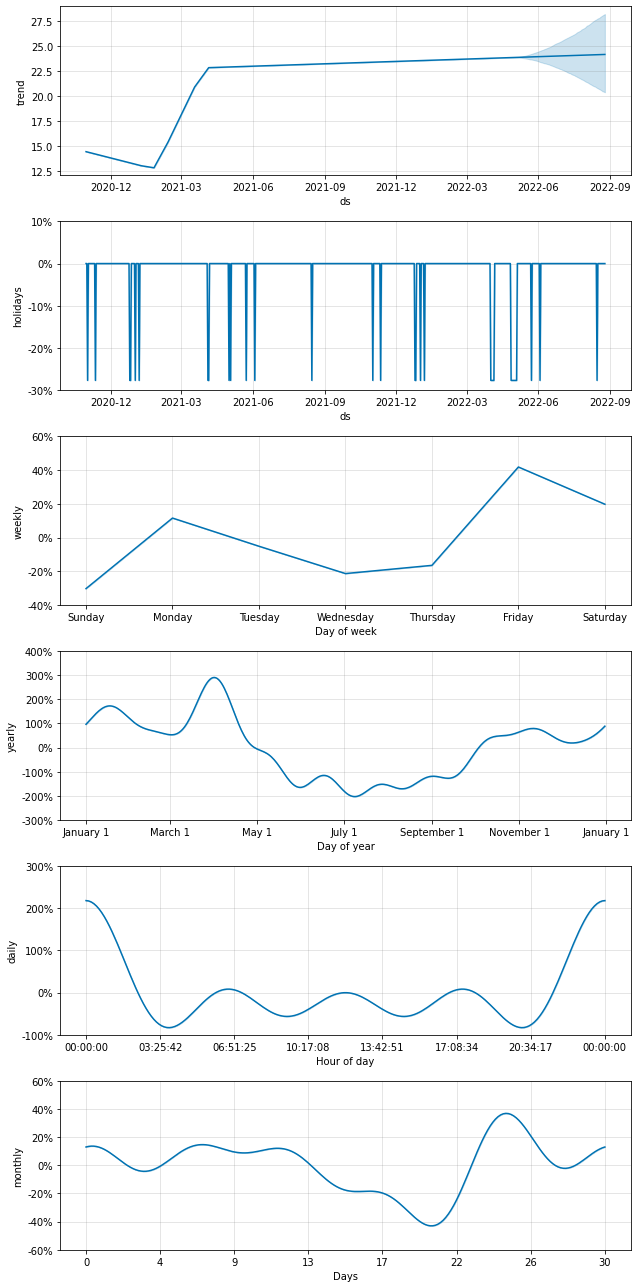

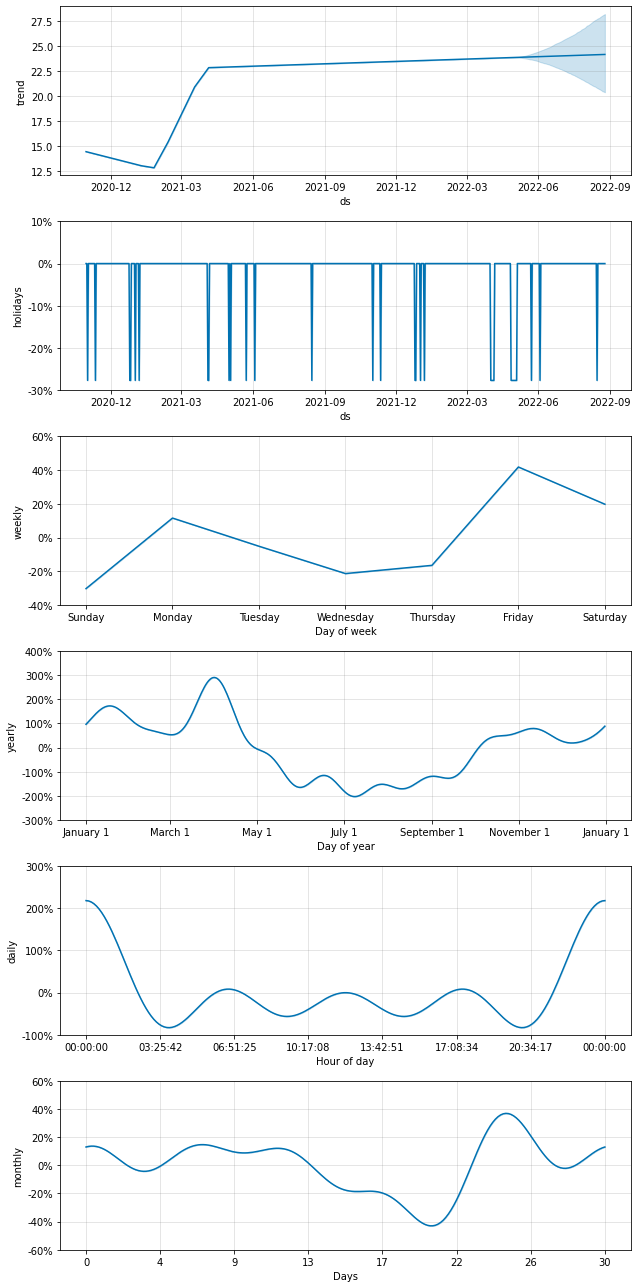

In [45]:
model_1.plot_components(forecast, uncertainty=True)

In [54]:
# seasonal components
seasonal_components = model_1.predict_seasonal_components(forecast).iloc[150+365]

In [55]:
seasonal_components

daily                         2.178376
daily_lower                   2.178376
daily_upper                   2.178376
holidays                      0.000000
holidays_lower                0.000000
holidays_upper                0.000000
monthly                      -0.190343
monthly_lower                -0.190343
monthly_upper                -0.190343
multiplicative_terms          4.751051
multiplicative_terms_lower    4.751051
multiplicative_terms_upper    4.751051
state_holiday                 0.000000
state_holiday_lower           0.000000
state_holiday_upper           0.000000
weekly                       -0.051224
weekly_lower                 -0.051224
weekly_upper                 -0.051224
yearly                        2.814243
yearly_lower                  2.814243
yearly_upper                  2.814243
additive_terms                0.000000
additive_terms_lower          0.000000
additive_terms_upper          0.000000
Name: 515, dtype: float64

In [370]:
# forecast_non_neural = model_1.predict(prediction_dates_wwa)
prediction_dates_wwa.head()

,ds
0,2020-10-30
1,2020-10-31
2,2020-11-01
3,2020-11-02
4,2020-11-03


In [760]:
# trenowanie i testowanie modelu Prophet w wielu punktach zbioru

first_id = 480
qm_30_dict = {}
qm_100_dict = {}
qm_nn_dict = {}
qm_full_dict = {}

while first_id < 640:
    
    model_100 = prophet.Prophet(
#                           interval_width = 0.95,
                          changepoint_prior_scale = 0.1,
                          seasonality_prior_scale = 10,
#                           holidays_prior_scale = 0.1,
                          changepoint_range=0.85,
                          yearly_seasonality=False,
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          seasonality_mode = 'multiplicative',
                          holidays = holidays
                           )
    model_100.add_seasonality(name='monthly', period=30.5, fourier_order=5)

    model_30 = prophet.Prophet(
    #                           interval_width = 0.95,
                              changepoint_prior_scale = 0.05,
                              seasonality_prior_scale = 10,
    #                           holidays_prior_scale = 0.1,
                              changepoint_range=0.8,
                              yearly_seasonality=False,
                              weekly_seasonality=True,
                              daily_seasonality=True,
                              seasonality_mode = 'multiplicative',
                              holidays = holidays
                               )
    
    model_full = prophet.Prophet(
#                           interval_width = 0.95,
                          changepoint_prior_scale = 0.05,
                          seasonality_prior_scale = 10,
#                           holidays_prior_scale = 0.1,
                          changepoint_range=0.8,
                          yearly_seasonality=True,
                          weekly_seasonality=True,
                          daily_seasonality=True,
                          seasonality_mode = 'multiplicative',
                          holidays = holidays
                           )
    model_full.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    

    neural_model = NeuralProphet(
        growth='off',
        yearly_seasonality=False,
        weekly_seasonality=True,
        daily_seasonality=False,
        n_lags=30,
#         n_forecasts=30,
        num_hidden_layers=4,
        d_hidden=32,
        learning_rate=0.05,
        epochs=100,
        ar_reg=1,
    )
    neural_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)


    dataset = prepared_warszawa_date_sales[:first_id]
    last_100_dataset = dataset[-100:]
    last_30_dataset = dataset[-30:]
    
#     print(last_30_dataset.index[-3:].head())
#     break;
    
#     uczenie modelu model_30 na ostatnich 30 rekoradach 
#     temp_model_30 = model_30
#     temp_model_30.fit(last_30_dataset.drop(last_30_dataset.index[-7:]))
    
#     uczenie modelu model_100 na ostatnich 100 rekoradach 
#     temp_model_100 = model_100
#     temp_model_100.fit(last_100_dataset.drop(last_100_dataset.index[-7:]))
    
#     model_full.fit(dataset.drop(dataset.index[-7:]))

    
    df_train, df_test = neural_model.split_df(dataset.drop(dataset.index[-120:]), freq='D', valid_p = 0.2)
    metrics = neural_model.fit(df_train, 
                    freq='D', 
                    validation_df=df_test,
                    )
#                     progress='plot')
    
    
#     forecast_30 = temp_model_30.predict(pd.DataFrame(last_30_dataset['ds']))
#     forecast_100 = temp_model_100.predict(pd.DataFrame(last_100_dataset['ds']))
#     forecast_full = model_full.predict(pd.DataFrame(dataset['ds'][-100:]))
    forecast_nn = neural_model.predict(pd.DataFrame(dataset[-200:]))

                                   
    y_true = dataset['y'][-120:].values 
#     y_pred_30 = forecast_30['yhat'][-7:].values
#     y_pred_100 = forecast_100['yhat'][-7:].values
#     y_pred_full = forecast_full['yhat'][-7:].values
    y_pred_nn = forecast_nn['yhat1'][-120:].values
    
#     print("Quality metrics for 30 days training")
#     qm_30 = quality_metrics(y_true, y_pred_30)
    
#     print("Quality metrics for 100 days training")
#     qm_100 = quality_metrics(y_true, y_pred_100)

#     print("Quality metrics for classic model")
#     qm_full = quality_metrics(y_true, y_pred_full)
    
    print("Quality metrics for NN")
    qm_nn = quality_metrics(y_true, y_pred_nn)
    
#     qm_30_dict[first_id] = qm_30
#     qm_100_dict[first_id] = qm_100
#     qm_full_dict[first_id] = qm_full
    qm_nn_dict[first_id] = qm_nn

    first_id += 20

# prepared_warszawa_date_sales.drop(prepared_warszawa_date_sales.index[-3:])

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.722% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.66% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
Epoch[100/100]: 100%|███████████████████| 100/100 [03:55<00:00,  2.36s/it, SmoothL1Loss=0.0029, MAE=6.94, RMSE=9.03, RegLoss=0.0566, MAE_val=10.6, RMSE_val=14, SmoothL1Loss_val=0.00671]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-pac

Quality metrics for NN
MAE: 14.97323923110962
RMSE: 18.904769361463728
MAPE: 16.342460989948652
MAX: 62.141746520996094


Epoch[100/100]: 100%|███████████████████| 100/100 [04:13<00:00,  2.54s/it, SmoothL1Loss=0.00489, MAE=8.25, RMSE=10.9, RegLoss=0.0411, MAE_val=13, RMSE_val=16.6, SmoothL1Loss_val=0.0106]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is 

Quality metrics for NN
MAE: 18.141320737202964
RMSE: 23.87142052629255
MAPE: 21.80583546681106
MAX: 72.83639526367188


Epoch[100/100]: 100%|██████████████████| 100/100 [04:26<00:00,  2.66s/it, SmoothL1Loss=0.00378, MAE=7.31, RMSE=9.6, RegLoss=0.0556, MAE_val=13.3, RMSE_val=17.2, SmoothL1Loss_val=0.0113]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is 

Quality metrics for NN
MAE: 17.954681968688966
RMSE: 24.03356764621075
MAPE: 20.32212801944954
MAX: 91.60636138916016


Epoch[100/100]: 100%|██████████████████| 100/100 [04:43<00:00,  2.83s/it, SmoothL1Loss=0.00542, MAE=8.45, RMSE=11.4, RegLoss=0.04, MAE_val=11.5, RMSE_val=14.2, SmoothL1Loss_val=0.00786]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is 

Quality metrics for NN
MAE: 16.423535092671713
RMSE: 21.2508720680823
MAPE: 16.83086402454775
MAX: 73.46715545654297


Epoch[100/100]: 100%|███████████████████| 100/100 [05:02<00:00,  3.02s/it, SmoothL1Loss=0.00403, MAE=7.5, RMSE=9.75, RegLoss=0.053, MAE_val=13.5, RMSE_val=16.8, SmoothL1Loss_val=0.0111]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is 

Quality metrics for NN
MAE: 20.64466053644816
RMSE: 26.19693499409037
MAPE: 20.945993329207624
MAX: 80.13423156738281


Epoch[100/100]: 100%|███████████████████| 100/100 [05:17<00:00,  3.18s/it, SmoothL1Loss=0.00523, MAE=8.38, RMSE=11.2, RegLoss=0.0441, MAE_val=14.4, RMSE_val=18, SmoothL1Loss_val=0.0128]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is 

Quality metrics for NN
MAE: 19.961604595184326
RMSE: 25.11380974728592
MAPE: 21.431387412586453
MAX: 73.80934143066406


Epoch[100/100]: 100%|█████████████████| 100/100 [05:29<00:00,  3.30s/it, SmoothL1Loss=0.00703, MAE=9.29, RMSE=12.6, RegLoss=0.0371, MAE_val=12.8, RMSE_val=16.5, SmoothL1Loss_val=0.0109]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is 

Quality metrics for NN
MAE: 19.045613606770832
RMSE: 24.51527033557018
MAPE: 22.559691461590106
MAX: 73.03194427490234


Epoch[100/100]: 100%|█████████████████| 100/100 [05:44<00:00,  3.44s/it, SmoothL1Loss=0.00593, MAE=8.88, RMSE=11.8, RegLoss=0.0348, MAE_val=15.7, RMSE_val=19.3, SmoothL1Loss_val=0.0151]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.502% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is 

Quality metrics for NN
MAE: 18.6506822903951
RMSE: 23.865972148975136
MAPE: 23.10261822139144
MAX: 73.1661148071289


In [761]:
# wyznaczenie srednich miar jakosci dla roznych puntow trenowania modelu 
# dla predykcji na 3 dni dla modeli uczonych na horyzontach 30 i 100 dniowych
rmse_30_list = []
mae_30_list = []
mape_30_list = []
max_30_list = []
rmse_100_list = []
mae_100_list = []
mape_100_list = []
max_100_list = []
rmse_nn_list = []
mae_nn_list = []
mape_nn_list = []
max_nn_list = []
rmse_full_list = []
mae_full_list = []
mape_full_list = []
max_full_list = []


# for key, value in qm_100_dict.items():
#     rmse_100_list.append(value[0])
#     mae_100_list.append(value[1])
#     mape_100_list.append(value[2])
#     max_100_list.append(value[3])

# for key, value in qm_full_dict.items():
#     rmse_full_list.append(value[0])
#     mae_full_list.append(value[1])
#     mape_full_list.append(value[2])
#     max_full_list.append(value[3])
    
for key, value in qm_nn_dict.items():
    rmse_nn_list.append(value[1])
    mae_nn_list.append(value[0])
    mape_nn_list.append(value[2])
    max_nn_list.append(value[3])

# rmse_30_avg = sum(rmse_30_list) / len(rmse_30_list)
# mae_30_avg = sum(mae_30_list) / len(mae_30_list)
# mape_30_avg = sum(mape_30_list) / len(mape_30_list)
# max_30_avg = sum(max_30_list) / len(max_30_list)
# rmse_100_avg = sum(rmse_100_list) / len(rmse_100_list)
# mae_100_avg = sum(mae_100_list) / len(mae_100_list)
# mape_100_avg = sum(mape_100_list) / len(mape_100_list)
# max_100_avg = sum(max_100_list) / len(max_100_list)
rmse_nn_avg = sum(rmse_nn_list) / len(rmse_nn_list)
mae_nn_avg = sum(mae_nn_list) / len(mae_nn_list)
mape_nn_avg = sum(mape_nn_list) / len(mape_nn_list)
max_nn_avg = sum(max_nn_list) / len(max_nn_list)
# rmse_full_avg = sum(rmse_full_list) / len(rmse_full_list)
# mae_full_avg = sum(mae_full_list) / len(mae_full_list)
# mape_full_avg = sum(mape_full_list) / len(mape_full_list)
# max_full_avg = sum(max_full_list) / len(max_full_list)



# print("Quality metrics for 30 days")
# print(rmse_100_avg)
# print(mae_100_avg)
# print(mape_100_avg)
# print(max_100_avg)

# print("Quality metrics for 100 days")
# print(rmse_full_avg)
# print(mae_full_avg)
# print(mape_full_avg)
# print(max_full_avg)

print("Quality metrics for NN days")
print(mae_nn_avg)
print(rmse_nn_avg)
print(mape_nn_avg)
print(max_nn_avg)

print(rmse_nn_list)


Quality metrics for NN days
18.22441725730896
23.46907710349637
20.41762236569158
75.02416133880615
[18.904769361463728, 23.87142052629255, 24.03356764621075, 21.2508720680823, 26.19693499409037, 25.11380974728592, 24.51527033557018, 23.865972148975136]


In [436]:
qm_nn_dict.items()

dict_items([(100, [25.106507619222004, 33.92237310188425, 35.73172269623276, 55.9345703125]), (150, [26.73941930135091, 27.39761102404797, 26.82679458202685, 31.16757583618164]), (200, [18.101876576741535, 20.019265600803, 88.65843544229428, 26.855873107910156]), (250, [16.225123087565105, 17.52099730841171, 45.27488684958835, 25.236099243164062]), (300, [10.201497395833334, 12.239310995034982, 11.408156298901455, 18.079879760742188]), (350, [15.854136149088541, 17.485969813093188, 17.746108542597707, 22.559524536132812]), (400, [17.448191324869793, 19.69268440887032, 16.688182333977405, 29.374053955078125]), (450, [27.975311279296875, 38.06155173770039, 31.464217031013828, 64.41697692871094])])

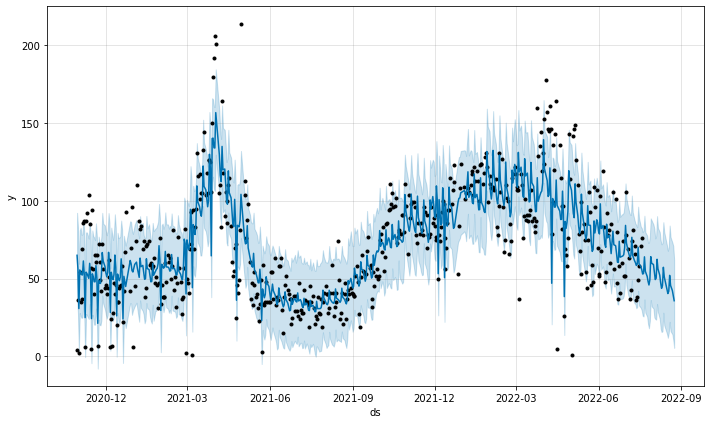

In [259]:
model_1.plot(forecast_non_neural);

In [389]:
# Neural Prophet model 1
neural_model_1 = NeuralProphet(
#     growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate = 0.01,
    seasonality_mode = 'additive',
#     ar_reg=1,
#     n_lags=3,
#     epochs=500,
)
# neural_model_1.add_seasonality(name='2_prediction_horizon', period=14, fourier_order=3)
# neural_model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [753]:
# Neural Prophet model 2

neural_model_2 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=30,
#     n_forecasts=30,
    ar_reg=1,
    num_hidden_layers=4,
#     num_hidden_layers=1,
    d_hidden=32,
    learning_rate = 0.05,
    epochs = 100,
)

# neural_model_1.add_seasonality(name='2_prediction_horizon', period=14, fourier_order=3)
# neural_model_1.add_seasonality(name='monthly', period=30.5, fourier_order=5)
neural_model_2.add_seasonality(name='monthly', period=30.5, fourier_order=5)

In [1]:
# Neural Prophet model 3

neural_model_3 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=7,
#     n_forecasts=7,
    num_hidden_layers=2,
    d_hidden=32,
    learning_rate=0.05,
    epochs=100,
#     seasonality_mode = 'multiplicative',
#     ar_reg=1,
)
# neural_model_3.add_seasonality(name='2_prediction_horizon', period=14, fourier_order=3)

neural_model_3.add_seasonality(name='monthly', period=30.5, fourier_order=5)

NameError: name 'NeuralProphet' is not defined

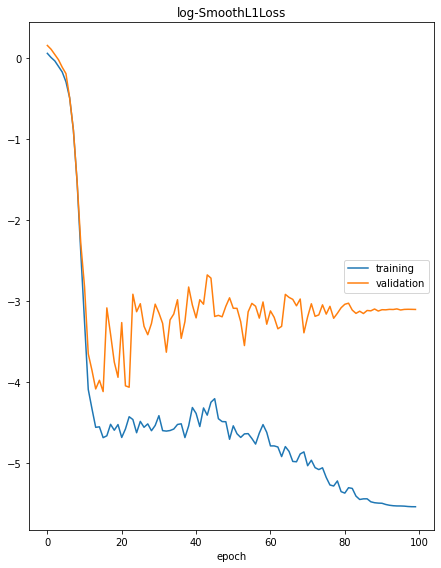

log-SmoothL1Loss
	training         	 (min:   -5.543, max:    0.055, cur:   -5.543)
	validation       	 (min:   -4.121, max:    0.153, cur:   -3.107)


In [771]:
# m = neural_model_1
m = neural_model_2
# m = neural_model_3

# df_train, df_test = m.split_df(wwa_train_last_100.drop(wwa_train_last_100.index[-7:]), freq='D', valid_p = 0.2)

df_train, df_test = m.split_df(wwa_train_30[130:], freq='D', valid_p = 0.2)

metrics = m.fit(df_train, 
                freq='D', 
                validation_df=df_test, 
                progress='plot')
# metrics = m.fit(wwa_train_7, freq='D')

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:2098: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.85% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
WARNING - (py.warnings._showwarnmsg) - /home/bdroix/.local/lib/python3.10/site-packages/neuralprophet/forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



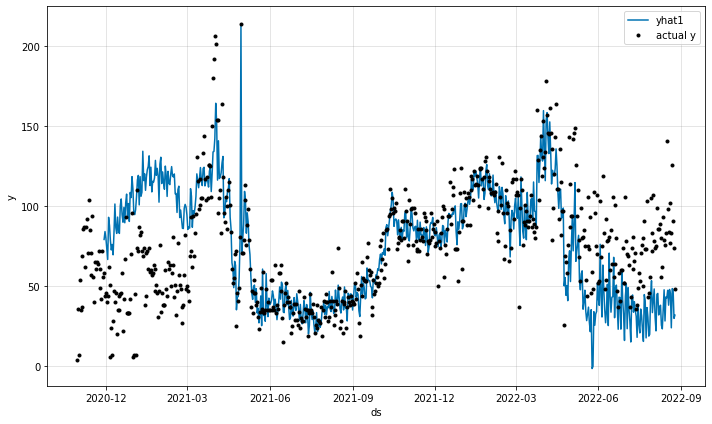

In [772]:
# Neural Prophet model prediction
forecast = m.predict(prepared_warszawa_date_sales)
fig = m.plot(forecast)

In [508]:
# predykcja sprzedazy dla przyszlych 3 dni
# # forecast = model_1.predict(prediction_dates_wwa)

prepared_warszawa_date_dates = []
for date in prepared_warszawa_date_sales.ds.to_list():
    prepared_warszawa_date_dates.append(str(date))
    
rows_ids = []
idx = 0

for index, row in forecast.iterrows():
    if str(row['ds'].date()) not in prepared_warszawa_date_dates:
        rows_ids.append(idx)
    idx += 1

forecast = forecast.drop(forecast.index[rows_ids])

In [756]:
# real = wwa_train_last_100['y'].values #bez niedziel


real = prepared_warszawa_date_sales['y'].values[-200:] #bez niedziel
pred = forecast['yhat1'].values[-200:] 
# print(pred)

# real = prepared_warszawa_date_sales['y'].values #bez niedziel
# pred = forecast['yhat1'].values 

# print("Metrics for whole training period")
# quality_metrics(real, pred)

print("Metrics for last 120 days")
quality_metrics(real[-120:], pred[-120:])

# print(prepared_warszawa_date_sales.head(15))
# # print(forecast.head(15))

# print(prepared_warszawa_date_sales.tail(30))
# print(forecast[['yhat1', 'ds']].tail(30))


# model_1.plot(forecast);

Metrics for last 120 days
MAE: 21.64347135225932
RMSE: 26.695405555265083
MAPE: 28.107919545266235
MAX: 87.06663131713867


[21.64347135225932, 26.695405555265083, 28.107919545266235, 87.06663131713867]

In [313]:
df_train.tail()

,ds,y
412,2021-12-16,94.0
413,2021-12-17,94.0
414,2021-12-18,115.0
415,2021-12-19,106.5
416,2021-12-20,98.0


In [ ]:
# predykcje sprzedazy dla calego kraju


In [ ]:
# trenowanie modelu
model_1.fit(train_30)

In [ ]:
# predykcja sprzedazy dla przyszlych 30 dni
forecast_30 = model_1.predict(train_30)

In [ ]:
# trenowanie modelu
model_1.fit(train_120)

In [ ]:
# predykcja sprzedazy dla przyszlych 3 dni
forecast_120 = model_1.predict(train_120)